# Задача 1
Пытаемся предугадать преступление, зная день недели, время суток и район, где оно было совершено

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
%matplotlib inline

In [2]:
# Путь к датасету надо ввести свой
data = pd.read_csv('d:\\Dataset\\police-department-incidents.csv', sep = ',', engine = 'python')

In [3]:
data

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,50436712,ASSAULT,BATTERY,Wednesday,2005-04-20T00:00:00,04:00,MISSION,NONE,18TH ST / CASTRO ST,-122.435003,37.760888,"{'human_address': '{""address"":"""",""city"":"""",""st...",5043671204134
1,80049078,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Sunday,2008-01-13T00:00:00,18:00,PARK,NONE,1100 Block of CLAYTON ST,-122.446838,37.762255,"{'human_address': '{""address"":"""",""city"":"""",""st...",8004907806304
2,130366639,ASSAULT,AGGRAVATED ASSAULT WITH A KNIFE,Sunday,2013-05-05T00:00:00,04:10,INGLESIDE,"ARREST, BOOKED",0 Block of SGTJOHNVYOUNG LN,-122.444707,37.724931,"{'human_address': '{""address"":"""",""city"":"""",""st...",13036663904012
3,30810835,DRIVING UNDER THE INFLUENCE,DRIVING WHILE UNDER THE INFLUENCE OF ALCOHOL,Tuesday,2003-07-08T00:00:00,01:00,SOUTHERN,"ARREST, BOOKED",MASON ST / TURK ST,-122.408954,37.783288,"{'human_address': '{""address"":"""",""city"":"""",""st...",3081083565050
4,130839567,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Friday,2013-10-04T00:00:00,20:53,TENDERLOIN,"ARREST, BOOKED",TURK ST / LEAVENWORTH ST,-122.414056,37.782793,"{'human_address': '{""address"":"""",""city"":"""",""st...",13083956765010
5,70838580,BURGLARY,"BURGLARY OF APARTMENT HOUSE, UNLAWFUL ENTRY",Tuesday,2007-08-14T00:00:00,07:00,NORTHERN,NONE,3100 Block of FRANKLIN ST,-122.426731,37.803467,"{'human_address': '{""address"":"""",""city"":"""",""st...",7083858005013
6,80233102,DRUG/NARCOTIC,POSSESSION OF MARIJUANA,Tuesday,2008-03-04T00:00:00,14:23,INGLESIDE,"ARREST, CITED",MISSION ST / PERSIA AV,-122.435977,37.723129,"{'human_address': '{""address"":"""",""city"":"""",""st...",8023310216010
7,60711805,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Wednesday,2006-07-05T00:00:00,15:50,INGLESIDE,"ARREST, CITED",2300 Block of SAN JOSE AV,-122.447241,37.720158,"{'human_address': '{""address"":"""",""city"":"""",""st...",6071180565016
8,40062593,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Wednesday,2003-12-10T00:00:00,09:30,INGLESIDE,NONE,0 Block of MOFFITT ST,-122.432788,37.737157,"{'human_address': '{""address"":"""",""city"":"""",""st...",4006259306304
9,110051822,NON-CRIMINAL,"STAY AWAY OR COURT ORDER, NON-DV RELATED",Monday,2011-01-17T00:00:00,15:35,INGLESIDE,NONE,600 Block of CAMPBELL AV,-122.408761,37.715900,"{'human_address': '{""address"":"""",""city"":"""",""st...",11005182271024


- `IncidntNum` - айди инцидента
- `Category` - категория инцидента
- `Descript` - краткое описание инцидента
- `DayOfWeek` - день недели, когда инцидент произошел
- `Date` - полная дата происшествия
- `Time` - время происшествия
- `PdDistrict` - район, в котором случился инцидент
- `Resolution` - результат выезда полиции
- `Address` - адрес происшествия
- `X` - координаты долготы
- `Y` - координаты широты
- `Location` - предыдущие три столбца в одном объекте
- `PdId` - айди в общей базе полиции

In [4]:
print(data.shape)
print(data.columns)

(2215024, 13)
Index(['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time',
       'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId'],
      dtype='object')


In [5]:
# Категорий преступлений очень много, поэтому оставим три самые интересные категории
data = data.query("Category not in ['OTHER OFFENSES','NON-CRIMINAL','LIQUOR LAWS', 'WARRANTS', 'MISSING PERSON', 'FRAUD', 'SUSPICIOUS OCC'\
                  'SECONDARY CODES', 'RECOVERED VEHICLE',  'EMBEZZLEMENT', 'BRIBERY', 'GAMBLING', 'TREA', 'PORNOGRAPHY/OBSCENE MAT',\
                  'WEAPON LAWS', 'FORGERY/COUNTERFEITING', 'TRESPASS', 'STOLEN PROPERTY', 'FAMILY OFFENSES', 'DRUNKENNESS',\
                  'RUNAWAY', 'EXTORTION', 'BAD CHECKS', 'VEHICLE THEFT', 'SUICIDE', 'SUSPICIOUS OCC', 'ARSON', 'SEX OFFENSES, FORCIBLE',\
                  'BURGLARY', 'DRIVING UNDER THE INFLUENCE', 'LOITERING','KIDNAPPING', 'SEX OFFENSES, NON FORCIBLE', 'DRUG/NARCOTIC', 'SECONDARY CODES','DISORDERLY CONDUCT', 'ASSAULT','ROBBERY' ]")
data = data.reset_index(drop=True)

In [6]:
# Категории, которые будем предугадывать
data['Category'].unique()

array(['LARCENY/THEFT', 'VANDALISM', 'PROSTITUTION'], dtype=object)

In [7]:
# Потрём столбцы, которые не нужны нам
data = data.drop('IncidntNum', axis = 1)\
            .drop('Descript', axis = 1)\
           .drop('X',   axis = 1)\
           .drop('Y', axis = 1).drop('Address', axis = 1)
data = data.drop('Date', axis = 1).drop('Resolution', axis = 1).drop('Location', axis = 1).drop('PdId', axis = 1)

In [8]:
# Два миллиона записей - это много. Обрежем.
data = data.drop(data.index[10000:])

In [9]:
# Время - понятие растяжимое. Сделаем так: [0:00, 7:00) - ночь(0), [7:00, 15:00) - день(1), [15:00, 0:00) - вечер(2).  
temp = data['Time'].str.replace('[:]', '.') 
temp = temp.astype(float)   
for i in range(data['Time'].size):
    if 0.00 <= temp[i] < 7.00:
        data.at[i, 'Time'] = 'Night'
    elif 7.00 <= temp[i] < 15.00:
        data.at[i, 'Time'] = 'Afternoon'
    else:
        data.at[i, 'Time'] = 'Evening'


In [10]:
data = data.reset_index(drop=True)
data

,Category,DayOfWeek,Time,PdDistrict
0,LARCENY/THEFT,Sunday,Evening,PARK
1,LARCENY/THEFT,Wednesday,Afternoon,INGLESIDE
2,LARCENY/THEFT,Saturday,Evening,NORTHERN
3,LARCENY/THEFT,Sunday,Evening,MISSION
4,LARCENY/THEFT,Tuesday,Evening,TARAVAL
5,LARCENY/THEFT,Sunday,Evening,INGLESIDE
6,LARCENY/THEFT,Wednesday,Evening,RICHMOND
7,LARCENY/THEFT,Thursday,Evening,SOUTHERN
8,LARCENY/THEFT,Saturday,Afternoon,INGLESIDE
9,VANDALISM,Sunday,Night,TENDERLOIN


In [11]:
data.describe()
# Уже отсюда видно, что в южном районе кражи в пятницу вечером - обычное явление

,Category,DayOfWeek,Time,PdDistrict
count,10000,10000,10000,10000
unique,3,7,3,10
top,LARCENY/THEFT,Friday,Evening,SOUTHERN
freq,7684,1567,5576,2121


In [12]:
# Дадим преступлениям ID, чтобы использовать числовой признак
idx_crime = [] #Concat this
for c in data['Category']:
    #print(np.argwhere(data['Category'].unique() == c)[0][0])
    idx_crime.append(np.argwhere(data['Category'].unique() == c)[0][0].astype(int))
    
df = pd.DataFrame(idx_crime, dtype='int')
df = df.rename(index=int, columns = {0:'CrimeID'})
data = pd.concat((df, data), axis = 1)
data

,CrimeID,Category,DayOfWeek,Time,PdDistrict
0,0,LARCENY/THEFT,Sunday,Evening,PARK
1,0,LARCENY/THEFT,Wednesday,Afternoon,INGLESIDE
2,0,LARCENY/THEFT,Saturday,Evening,NORTHERN
3,0,LARCENY/THEFT,Sunday,Evening,MISSION
4,0,LARCENY/THEFT,Tuesday,Evening,TARAVAL
5,0,LARCENY/THEFT,Sunday,Evening,INGLESIDE
6,0,LARCENY/THEFT,Wednesday,Evening,RICHMOND
7,0,LARCENY/THEFT,Thursday,Evening,SOUTHERN
8,0,LARCENY/THEFT,Saturday,Afternoon,INGLESIDE
9,1,VANDALISM,Sunday,Night,TENDERLOIN


In [13]:
# Работаем с данными. Далее векторизация и нормализация
data = data.drop(('Category'), axis = 1)
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

['DayOfWeek', 'Time', 'PdDistrict']
['CrimeID']


In [14]:
data_describe = data.describe(include = [object])
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)

[] ['DayOfWeek', 'Time', 'PdDistrict']


In [15]:
data_nonbinary = pd.get_dummies(data[nonbinary_columns])
print(data_nonbinary.columns)

Index(['DayOfWeek_Friday', 'DayOfWeek_Monday', 'DayOfWeek_Saturday',
       'DayOfWeek_Sunday', 'DayOfWeek_Thursday', 'DayOfWeek_Tuesday',
       'DayOfWeek_Wednesday', 'Time_Afternoon', 'Time_Evening', 'Time_Night',
       'PdDistrict_BAYVIEW', 'PdDistrict_CENTRAL', 'PdDistrict_INGLESIDE',
       'PdDistrict_MISSION', 'PdDistrict_NORTHERN', 'PdDistrict_PARK',
       'PdDistrict_RICHMOND', 'PdDistrict_SOUTHERN', 'PdDistrict_TARAVAL',
       'PdDistrict_TENDERLOIN'],
      dtype='object')


In [16]:
data_numerical = data[numerical_columns]
data_numerical.describe()

,CrimeID
count,10000.000000
mean,0.266900
std,0.516034
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2.000000


In [17]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)

In [18]:
data_numerical.describe()

,CrimeID
count,1.000000e+04
mean,-4.814149e-16
std,1.000000e+00
min,-5.172141e-01
25%,-5.172141e-01
50%,-5.172141e-01
75%,-5.172141e-01
max,3.358500e+00


In [19]:
data_new = pd.concat((data_numerical, data_nonbinary, data[binary_columns]), axis = 1)
print(data.shape)

(10000, 4)


In [20]:
# Готовим выборки для обучения
X = data_new.drop(('CrimeID'), axis = 1) # выбрасываем столбец 'class'
y = data_new['CrimeID']
feature_names = X.columns


In [21]:
lab_enc = preprocessing.LabelEncoder()
training_scores_encoded = lab_enc.fit_transform(y)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, training_scores_encoded, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

7000 3000


In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
#knn.set_params(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [24]:
y_train_predict = knn.predict(X_train)
y_test_predict = knn.predict(X_test)

err_train = np.mean(y_train != y_train_predict)
err_test  = np.mean(y_test  != y_test_predict)

print(err_train, err_test)

0.233 0.248


## Как видно, ошибка вообще достаточно высокая. Однако, дельта ошибок не достаточно высокая, чтобы сделать вывод, что произошло переобучения

# Метод ближайших соседей

In [25]:
# Как показывает практика, 25 соседей достаточно для некоторого уменьшения ошибки и дельты ошибок.
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.23071428571428576 25


In [26]:
knn = KNeighborsClassifier(n_neighbors = best_n_neighbors).fit(X_train, y_train)

err_train = np.mean(y_train != knn.predict(X_train))
err_test  = np.mean(y_test  != knn.predict(X_test))

print(err_train, err_test)

0.23014285714285715 0.23733333333333334


## Метод ближайших соседей делает результаты лучше

# Задача 2

## Обучаем нейросеть, делаем выводы

In [27]:
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes = (100,), solver = 'lbfgs', 
                          activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

# Насколько всё хорошо?

In [28]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

In [29]:
print(np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred))

0.2292857142857143 0.234


In [30]:
print(mlp_model.score(X_train, y_train), mlp_model.score(X_test, y_test))

0.7707142857142857 0.766


## Результаты ошибки немного лучше, чем в KNN

## Подбор гиперпараметров
Подберем оптимальное значение параметра регуляризации alpha

In [31]:

alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), 
                              solver = 'lbfgs', activation = 'logistic', random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

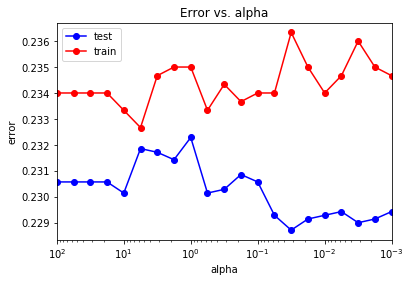

In [32]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'test')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'train')
plt.xlim([np.max(alpha_arr), np.min(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

In [33]:
# Мин. значение ошибки
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.2287142857142857 0.23266666666666666


In [34]:
# Получим оптимальное значение параметра регуляризации alpha:

In [35]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[5.62341325]


In [36]:
alpha_opt = alpha_opt[0]

In [37]:
# Рассмотрим классификатор с оптимальным параметром. Для этого повторим обучение и посмотрим на ошибку.

In [38]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (100,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.23185714285714284
0.23266666666666666


## Рассмотрим метрики качества

Матрица рассогласования

In [39]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, y_test))

[[2291  583  108]
 [   7   11    0]
 [   0    0    0]]


In [ ]:
Другие метрики

In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       0.77      1.00      0.87      2298
          1       0.61      0.02      0.04       594
          2       0.00      0.00      0.00       108

avg / total       0.71      0.77      0.67      3000



D:\PF\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Выводы

Ошибка всё равно достаточно высока. Вероятно, преступления - это не та категория событий, которую можно предугатать очень хорошо, поскольку влияние человеческого фактора здесь высока. 
Не всё так плохо, сеть находит связи, например, что преступления с кражами происходят обычно вечером. И обычно ближе к выходным